In [ ]:
"""
单年份数据和双年份数据都按15，16和15-16重复drought区域分开计算
"""

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from openpyxl import load_workbook
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import multiprocessing
import os
import time
import gloce as gc
from osgeo import gdal
from osgeo import gdalconst
from mpl_toolkits.basemap import Basemap
from glob import glob
from math import ceil
import seaborn as sns
from scipy import stats
from scipy.stats import gaussian_kde
#return im_data, im_width, im_height, im_geotrans, im_proj
def read_img(filename):
    dt = gdal.Open(filename)
    im_width = dt.RasterXSize
    im_height = dt.RasterYSize
    im_bands = dt.RasterCount
    im_geotrans = dt.GetGeoTransform()
    im_proj = dt.GetProjection()
    im_data = dt.ReadAsArray(0,0,im_width,im_height)
    return im_data, im_width, im_height, im_geotrans, im_proj
def write_img(filename, im_proj, im_geotrans, im_data):
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32
    if len(im_data.shape) == 3:
        im_bands, im_height, im_width = im_data.shape
    else:
        im_bands, (im_height, im_width) = 1, im_data.shape
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(filename, im_width, im_height, im_bands, datatype)
    dataset.SetGeoTransform(im_geotrans)
    dataset.SetProjection(im_proj)
    if im_bands == 1:
        dataset.GetRasterBand(1).WriteArray(im_data)
    else:
        for i in range(im_bands):
            dataset.GetRasterBand(i + 1).WriteArray(im_data[i])
spei_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/'
sm_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
soil_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
drv_path='//weili/User2/mxsun/CESS_230818/Pattern_drive/'

# Prepare data

In [2]:
gdal.Warp(spei_path+'evaporation_mean_2015_001.tif',
      spei_path+'evaporation_mean_2015.tif',
      dstSRS='EPSG:4326',
      outputBounds = [-26,-40,53,25],
      xRes=0.01,
      yRes=0.01,
      targetAlignedPixels=True,
      resampleAlg = gdalconst.GRA_NearestNeighbour,
      creationOptions = ["COMPRESS=LZW"])
gdal.Warp(spei_path+'evaporation_mean_2016_001.tif',
      spei_path+'evaporation_mean_2016.tif',
      dstSRS='EPSG:4326',
      outputBounds = [-26,-40,53,25],
      xRes=0.01,
      yRes=0.01,
      targetAlignedPixels=True,
      resampleAlg = gdalconst.GRA_NearestNeighbour,
      creationOptions = ["COMPRESS=LZW"])

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x000002CC3E0D77B0> >

In [4]:
gdal.Warp(spei_path+'SPEI_yrMean_afr_15_001_sub.tif',
      spei_path+'SPEI_yrMean_afr_15_001',
      dstSRS='EPSG:4326',
      outputBounds = [-26,-40,53,25],
      xRes=0.01,
      yRes=0.01,
      targetAlignedPixels=True,
      resampleAlg = gdalconst.GRA_NearestNeighbour,
      creationOptions = ["COMPRESS=LZW"])
gdal.Warp(spei_path+'SPEI_yrMean_afr_16_001_sub.tif',
      spei_path+'SPEI_yrMean_afr_16_001',
      dstSRS='EPSG:4326',
      outputBounds = [-26,-40,53,25],
      xRes=0.01,
      yRes=0.01,
      targetAlignedPixels=True,
      resampleAlg = gdalconst.GRA_NearestNeighbour,
      creationOptions = ["COMPRESS=LZW"])

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x000002CC7F2D3EA0> >

## drivers

In [51]:
#---------------------------单年份data----------------------------------
#-----vegetation-----
treeH = read_img(spei_path+'African_th2019_001_230525.tif')[0]
tc = read_img(spei_path+'Africa_tc2019_mosaic_001_fillNaN_231215.tif')[0]#Planet TC,用Hansen TC填补空缺值
Bio=read_img(spei_path+'African_CCIbiomass_001_230525.tif')[0]
# ------soil--------
soc=read_img(soil_path+'OCSTHA_M_sd_5km_ll_af001.tif')[0]
clay=read_img(soil_path+'CLYPPT_M_sl_5km_ll_af001.tif')[0]
bulk=read_img(soil_path+'BLDFIE_M_sl5km_ll_af001.tif')[0]

#-------------双年份data,需要准备15年、16年和15-16年均值--------------------
et=read_img(drv_path+'evaporation_mean_2015-16_001_afr.tif')[0]
lst=read_img(spei_path+'lst_1516_afr_001.tif')[0]
lst=lst*0.02-273.15
spei=read_img(spei_path+'SPEI_yrMean_afr_1516_001_sub.tif')[0]
dens=read_img(spei_path+'ele-density_001_231123.tif')[0]
print(np.min(dens),np.max(dens))

nan nan


In [52]:
treeH[treeH==0]=np.nan
tc=tc.astype(np.float32)
tc[tc==0]=np.nan
tc[tc>100]=np.nan
Bio=Bio.astype(np.float32)
Bio[Bio==0]=np.nan

soc[soc==-32768]=np.nan
clay[clay==255]=np.nan
bulk[bulk==-32768]=np.nan

et[et==0]=np.nan
lst[lst==0]=np.nan
spei[spei==0]=np.nan

albedo[albedo==0]=np.nan

## drought&elephants

In [53]:
DEAA=read_img(spei_path+'SPEI_deaa001_240504.tif')[0]
DAA=read_img(spei_path+'SPEI_daa001_240504.tif')[0]
DEAA[DEAA==0]=np.nan
DAA[DAA==0]=np.nan

## resistance

In [54]:
ndvi_res=read_img(spei_path+'ndvi_resistance_230321.tif')[0]
csif_res=read_img(spei_path+'csif_resistance_230321.tif')[0]
ndvi_res[ndvi_res==0]=np.nan
csif_res[csif_res==0]=np.nan

## mask

In [55]:
dem=read_img(spei_path+'gtopoDEM_afr_001.tif')[0]
slope=read_img(spei_path+'gtopoSlope_afr_001.tif')[0]
dem=dem.astype(np.float32)
dem[dem==-9999]=np.nan
slope[slope==0]=np.nan

hfp = read_img(spei_path+'hfp2018_Afirca_001_230525.tif')[0]
hfp[hfp<=15]=1
hfp[hfp>1]=np.nan
mask=hfp
mask[~np.isnan(mask)]=1
np.nanmin(mask),np.nanmax(mask)

(1.0, 1.0)

# paired sites

In [58]:
"""
2023/11/25
supply paired sites methods. 
Be notes the  suppled detail locates should be consistence with all factors.
"""
# current shape:(6500,7900)
#0.01deg to 0.25 deg window size=625 pixels
#6500/25,7900/25...(260,316)
def slide_window_mean(s,dist,res):
    #s: window size
    #dist: disturb array
    #res: resistance and resilience array
    mean_arr=np.zeros((260,316))
    weight_arr=np.zeros((260,316))
    loc=np.zeros((260,316)) #record the location of supplied sites
    sl=np.ones((25,25))
    for i in range(260):
        #print("sliding", i, "line...")
        for j in range(316):
            bloc_dist=dist[i*s:(i+1)*s,j*s:(j+1)*s]
            res_dist=res[i*s:(i+1)*s,j*s:(j+1)*s]
            res_mask=np.multiply(bloc_dist,res_dist)#product restance array controled by window
            count=np.count_nonzero(~np.isnan(res_mask))
            weight=count/625#calculate the weight
            if weight>0.05:
                weight_arr[i,j]=weight
                dt=np.where(res_mask!=np.nan,res_mask,np.nan)
                mean_arr[i,j]=np.nanmean(res_mask)#calculate the mean value
                loc[i,j]=9
            else:
                bloc_dist_a=[] #should be 8 nums [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                res_dist_a=[] #should be 8 nums
                res_mask_pool=[]
                weight_pool=[]
                for m in [-1,1]:
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    bloc_dist_a.append(dist[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    res_dist_a.append(res[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                bloc_dist_a.append(dist[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                bloc_dist_a.append(dist[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                res_dist_a.append(res[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                res_dist_a.append(res[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                #the smooth order of a 9 value array is [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                for n in range(len(bloc_dist_a)): #the length is 8
                    res_mask_pool.append(np.multiply(bloc_dist_a[n],res_dist_a[n]))
                    weight_pool.append(np.count_nonzero(~np.isnan(res_mask_pool[n]))/625)#calculate the weight
                key=np.argmax(weight_pool) 
                # Key used to loc the supplied direction, the key-value consistience with [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                if weight_pool[key] > 0.05:
                    weight_arr[i,j]=weight_pool[key]
                    dt1=np.where(res_mask_pool[key]!=np.nan,res_mask_pool[key],np.nan)
                    mean_arr[i,j]=np.nanmean(dt1)#calculate the mean value
                    loc[i,j]=key+1
                else:
                    mean_arr[i,j]=np.nan#calculate the mean value
                    loc[i,j]=np.nan
    return mean_arr
dist_pool=[DEAA*mask,DAA*mask]
res_pool=[ndvi_res,csif_res,treeH,tc,Bio,et,soc,clay,bulk,lst,spei,dens,dem,slope] #protect need conver to fraction
dist_name=['DEAA','DAA']
res_name=['ndvi_res','csif_res','treeH','tc','Bio','et','soc','clay','bulk','lst','spei','dens','dem','slope']
# protect 最后直接加上去
aa=[]
aa_name=[]
for i in range(2):
    for j in range(14):
        el=[25,dist_pool[i],res_pool[j]]
        aa.append(el)
        aa_name.append('pattern-drivers_{}_{}_0.25deg_240506.npy'.format(dist_name[i],res_name[j]))
aa_name

['pattern-drivers_DEAA_ndvi_res_0.25deg_240506.npy',
 'pattern-drivers_DEAA_csif_res_0.25deg_240506.npy',
 'pattern-drivers_DEAA_treeH_0.25deg_240506.npy',
 'pattern-drivers_DEAA_tc_0.25deg_240506.npy',
 'pattern-drivers_DEAA_Bio_0.25deg_240506.npy',
 'pattern-drivers_DEAA_et_0.25deg_240506.npy',
 'pattern-drivers_DEAA_soc_0.25deg_240506.npy',
 'pattern-drivers_DEAA_clay_0.25deg_240506.npy',
 'pattern-drivers_DEAA_bulk_0.25deg_240506.npy',
 'pattern-drivers_DEAA_lst_0.25deg_240506.npy',
 'pattern-drivers_DEAA_spei_0.25deg_240506.npy',
 'pattern-drivers_DEAA_dens_0.25deg_240506.npy',
 'pattern-drivers_DEAA_dem_0.25deg_240506.npy',
 'pattern-drivers_DEAA_slope_0.25deg_240506.npy',
 'pattern-drivers_DAA_ndvi_res_0.25deg_240506.npy',
 'pattern-drivers_DAA_csif_res_0.25deg_240506.npy',
 'pattern-drivers_DAA_treeH_0.25deg_240506.npy',
 'pattern-drivers_DAA_tc_0.25deg_240506.npy',
 'pattern-drivers_DAA_Bio_0.25deg_240506.npy',
 'pattern-drivers_DAA_et_0.25deg_240506.npy',
 'pattern-drivers_DA

In [59]:
for i in range(28):
    print('执行任务%s (%s)...' % (i, os.getpid()))
    kk=slide_window_mean(aa[i][0],aa[i][1],aa[i][2])
    np.save(drv_path+aa_name[i],kk)

执行任务0 (34296)...
执行任务1 (34296)...
执行任务2 (34296)...
执行任务3 (34296)...
执行任务4 (34296)...
执行任务5 (34296)...
执行任务6 (34296)...
执行任务7 (34296)...
执行任务8 (34296)...
执行任务9 (34296)...
执行任务10 (34296)...
执行任务11 (34296)...
执行任务12 (34296)...
执行任务13 (34296)...
执行任务14 (34296)...
执行任务15 (34296)...
执行任务16 (34296)...
执行任务17 (34296)...
执行任务18 (34296)...
执行任务19 (34296)...
执行任务20 (34296)...
执行任务21 (34296)...
执行任务22 (34296)...
执行任务23 (34296)...
执行任务24 (34296)...
执行任务25 (34296)...
执行任务26 (34296)...
执行任务27 (34296)...


In [60]:
#--------------------elephant density---------------------------------------
# check the Δ dem and Δ slope distribution
dem1=np.load(drv_path+'pattern-drivers_DEAA_dem_0.25deg_240506.npy',allow_pickle=True)
dem2=np.load(drv_path+'pattern-drivers_DAA_dem_0.25deg_240506.npy',allow_pickle=True)
dem_differ=dem1-dem2

slo1=np.load(drv_path+'pattern-drivers_DEAA_slope_0.25deg_240506.npy',allow_pickle=True)
slo2=np.load(drv_path+'pattern-drivers_DAA_slope_0.25deg_240506.npy',allow_pickle=True)
slo_differ=slo1-slo2

dem_differ[dem_differ<-200]=np.nan
dem_differ[dem_differ>200]=np.nan
dem_differ[~np.isnan(dem_differ)]=1
slo_differ[slo_differ<-10]=np.nan
slo_differ[slo_differ>10]=np.nan
slo_differ[~np.isnan(slo_differ)]=1
# 每一层数据位置对应,建立mask
dd_mask=np.ones((260,316))*dem_differ*slo_differ

# Add mean paras
res_name=['ndvi_res','csif_res','treeH','tc','Bio','et','soc','clay','bulk','lst','spei']
delta=[]
delta_m=[]
for i in range(11):
    f1=np.load(drv_path+'pattern-drivers_DEAA_{}_0.25deg_240506.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    f2=np.load(drv_path+'pattern-drivers_DAA_{}_0.25deg_240506.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    ff=f1-f2
    delta.append(ff)
    if i>1:
        ff1=(f1+f2)/2
        delta_m.append(ff1)
#dens不一样，因为dens和DEAA重叠，DAA没有dens，所以delta dens就是DEAA部分
dens_a=np.load(drv_path+'pattern-drivers_DEAA_dens_0.25deg_240506.npy',allow_pickle=True)*dd_mask
delta_m.append(dens_a)
len(delta),len(delta_m)

(11, 10)

In [61]:
delta=np.concatenate((delta,delta_m),axis=0)
delta.shape

(21, 260, 316)

In [62]:
# 每一层数据位置对应,建立mask,使得每一层有效数值位置对应
dd=np.copy(delta)
dd[~np.isnan(dd)]=1
cc_mask=np.ones((260,316))
for i in range(21):
    cc_mask=cc_mask*dd[i]

delta_dd=np.copy(delta)
for i in range(21):
    delta_dd[i]=delta[i]*cc_mask
    print(np.count_nonzero(~np.isnan(delta_dd[i])))

2639
2639
2639
2639
2639
2639
2639
2639
2639
2639
2639
2639
2639
2639
2639
2639
2639
2639
2639
2639
2639


In [63]:
def kill_nan(dt):
    a=dt.ravel()
    a=a[~np.isnan(a)]
    a=list(a)
    return a
pd_delta=[]
for i in range(21):
    pd_delta.append(kill_nan(delta_dd[i]))
#Δndvi_res,Δcsif_res,ΔtreeH,Δtc,ΔBio,Δsoc,Δclay,Δbulk,Δet,Δlst,Δspei,
#treeH_m,tc_m,Bio_m,soc_m,clay_m,bulk_m,et_m,lst_m,spei_m,
#elephant density
#['ndvi_res','csif_res','treeH','tc','Bio','et','soc','clay','bulk','lst','spei']
pd_delta=list(map(list, zip(*pd_delta)))#list转置
df=pd.DataFrame(pd_delta,columns=['NDVI_res','SIF_res','TH','TC','AGB','ET','SOC','Clay','Bulk','LST','SPEI',
                                  'TH_m','TC_m','AGB_m','ET_m','SOC_m','Clay_m','Bulk_m','LST_m','SPEI_m','Ele_Dens'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2639 entries, 0 to 2638
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   NDVI_res  2639 non-null   float64
 1   SIF_res   2639 non-null   float64
 2   TH        2639 non-null   float64
 3   TC        2639 non-null   float64
 4   AGB       2639 non-null   float64
 5   ET        2639 non-null   float64
 6   SOC       2639 non-null   float64
 7   Clay      2639 non-null   float64
 8   Bulk      2639 non-null   float64
 9   LST       2639 non-null   float64
 10  SPEI      2639 non-null   float64
 11  TH_m      2639 non-null   float64
 12  TC_m      2639 non-null   float64
 13  AGB_m     2639 non-null   float64
 14  ET_m      2639 non-null   float64
 15  SOC_m     2639 non-null   float64
 16  Clay_m    2639 non-null   float64
 17  Bulk_m    2639 non-null   float64
 18  LST_m     2639 non-null   float64
 19  SPEI_m    2639 non-null   float64
 20  Ele_Dens  2639 non-null   floa

In [64]:
df.to_csv(drv_path+'pattern-drivers_difference_240506.csv',header=True,index=True)

# CatBoostClassifier

## ndvi_res

In [34]:
from sklearn.impute import SimpleImputer
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
import shap
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
#['NDVI_res','SIF_res','TH','TC','AGB','ET','SOC','Clay','Bulk','LST','SPEI','TH_m','TC_m','AGB_m','ET_m','SOC_m','Clay_m','Bulk_m','LST_m','SPEI_m','Ele_Dens'])
ddf=df.copy()
ddf["NDVI_res"][df.NDVI_res<0]=-1
ddf["NDVI_res"][df.NDVI_res>0]=1

y = ddf['NDVI_res']
x = ddf.drop(['NDVI_res','SIF_res'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,shuffle=True, random_state=128)

In [23]:
from catboost import CatBoostClassifier
param_grid = {
    'iterations': [200, 500, 1000, 2000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [3, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 10],
    'bagging_temperature': [0.0, 0.5, 1.0, 2.0],
    'random_strength': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
    'border_count': [32, 64, 128, 255],
    'min_data_in_leaf': [1, 10, 20, 50],
    'colsample_bylevel': [0.5,0.75,1],
    'subsample': [0.5,0.75,1],
    'early_stopping_rounds': [30, 50]
}
model = CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', verbose=False)
random_search  = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=100, scoring='roc_auc', cv=10, verbose=2, n_jobs=-1)
random_search.fit(X_train, y_train)
best_params = random_search.best_params_
best_params

Fitting 10 folds for each of 100 candidates, totalling 1000 fits



8 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\dess\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dess\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py", line 5100, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\dess\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py", line 2319, in _fit
    self._t

{'subsample': 1,
 'random_strength': 0.0,
 'min_data_in_leaf': 50,
 'learning_rate': 0.05,
 'l2_leaf_reg': 1,
 'iterations': 2000,
 'early_stopping_rounds': 50,
 'depth': 8,
 'colsample_bylevel': 0.75,
 'border_count': 128,
 'bagging_temperature': 0.0}

In [37]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef
best_params={'subsample': 1,
 'random_strength': 0.0,
 'min_data_in_leaf': 50,
 'learning_rate': 0.05,
 'l2_leaf_reg': 1,
 'iterations': 2000,
 'early_stopping_rounds': 50,
 'depth': 8,
 'colsample_bylevel': 0.75,
 'border_count': 128,
 'bagging_temperature': 0.0}
model = CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', verbose=False, **best_params)
#train model
model.fit(X_train, y_train)
# 评估
y_score = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_score)
print("AUC Score:", auc_score)
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
balanced_accuracy = balanced_accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
#mcc = matthews_corrcoef(y_test, predictions)

print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
#print("MCC:", mcc)

AUC Score: 0.8050495100171431
Accuracy: 0.7335858585858586
Balanced Accuracy: 0.7310019701660568
F1 Score: 0.7549361207897793
Precision: 0.7336343115124153
Recall: 0.777511961722488


0.1864854070122359 AGB_m
0.18841833462847346 Bulk_m
0.2280308797341838 TC_m
0.23085562062042764 AGB
0.2905283993299319 SOC_m
0.30638529745447324 TC
0.3069804573964031 Ele_Dens
0.3196688960768807 TH_m
0.324116742079441 ET_m
0.3407662870087765 Bulk
0.35781945233571494 Clay_m
0.37784341692778084 SPEI
0.4051686321369782 TH
0.4448365515801069 SPEI_m
0.45355684172598004 Clay
0.46317165763444507 LST_m
0.49760321962555676 ET
0.49952333369893853 SOC
1.0 LST


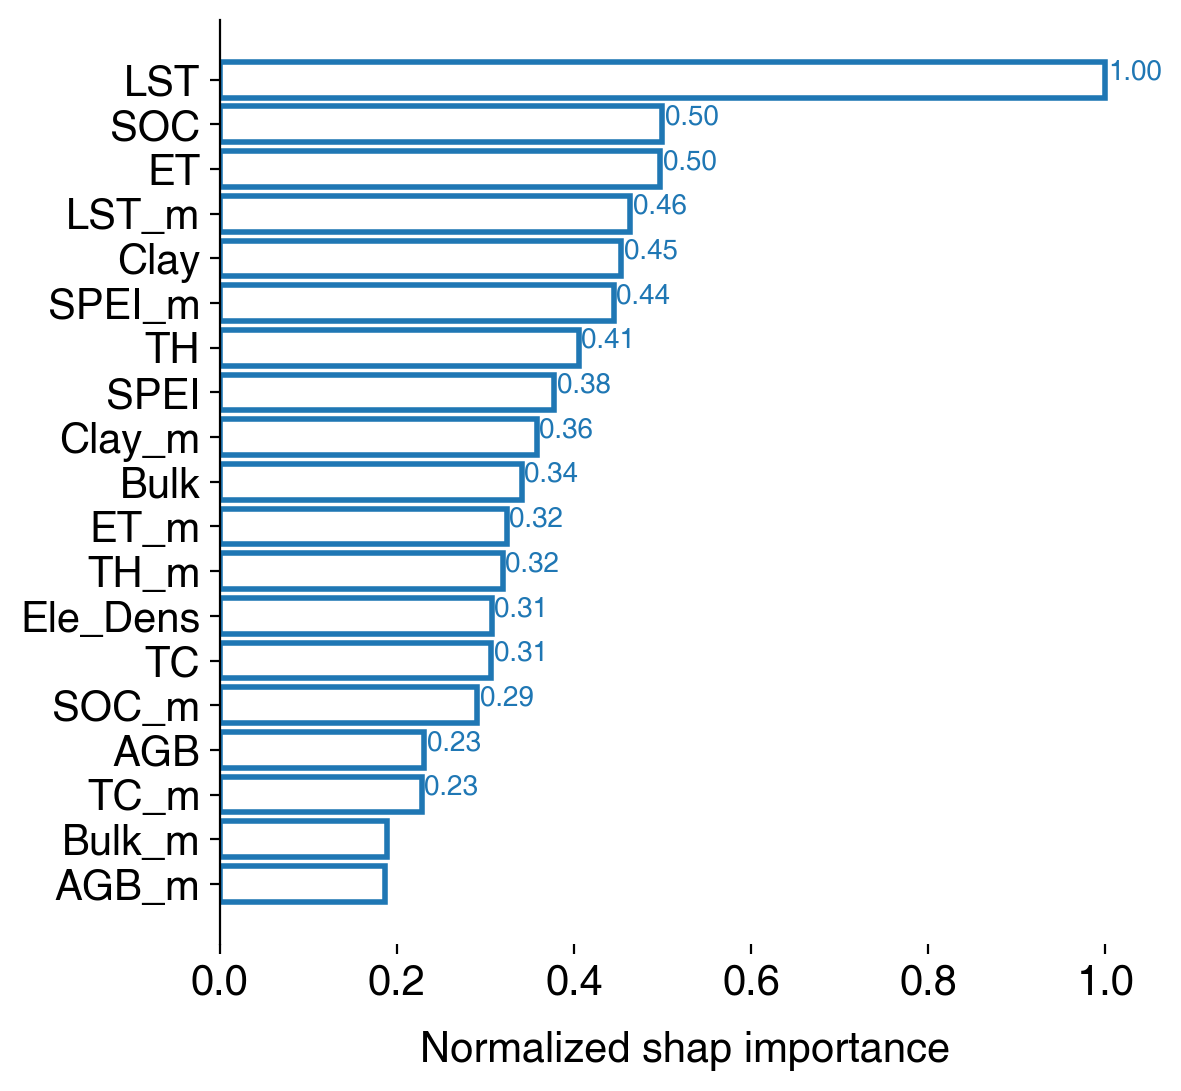

In [36]:
import shap
from sklearn.inspection import permutation_importance
explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
# SHAP value
shap_values = explainer.shap_values(X_test)
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=0)
# normalized
normalized_shap_importance = np.abs(shap_values).mean(axis=0) / np.max(np.abs(shap_values).mean(axis=0))
normalized_perm_importance = perm_importance.importances_mean / np.max(perm_importance.importances_mean)
# ascending
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'SHAP Importance': normalized_shap_importance, 'Perm Importance': normalized_perm_importance})
feature_importance_df = feature_importance_df.sort_values(by='SHAP Importance', ascending=False)
labels=list(reversed([i for i in feature_importance_df['Feature']]))
value=list(reversed([i for i in feature_importance_df['SHAP Importance']]))
#Fig
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#fig.subplots_adjust(wspace=0.2,hspace=0.4, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 16}
plt.rc('font', **font)  # pass in the font dict as kwargs
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6), sharex=False,sharey=False)
for i in range(len(value)):
    if value[i]>=0.2:
        ax.barh(labels[i], value[i], color='none',edgecolor='C0', linewidth=2,label='Shapley value')
    else:
        ax.barh(labels[i], value[i], color='none',edgecolor='C0', linewidth=2,label='Shapley value')
for a,b in zip(value,labels): # 添加数字标签
    print(a,b)
    if a>=0.2:
        ax.text(a+0.003, b,'%.2f'%float(a), color='C0',fontsize =10) # a+0.001代表标签位置在柱形图上方0.001处
ax.tick_params(labelsize=15)
#ax.set_xlim(0, 0.18)
#ax.set_xticks(np.arange(0, 0.18,0.05))
ax.set_xlabel('Normalized shap importance',fontsize =15,labelpad=10) # x 轴
#ax3.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)

## csif_res

In [27]:
ddf=df.copy()
ddf["SIF_res"][df.SIF_res<0]=-1
ddf["SIF_res"][df.SIF_res>0]=1

y = ddf['SIF_res']
x = ddf.drop(['NDVI_res','SIF_res'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,shuffle=True, random_state=128)

In [28]:
from catboost import CatBoostClassifier
param_grid = {
    'iterations': [200, 500, 1000, 2000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [3, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 10],
    'bagging_temperature': [0.0, 0.5, 1.0, 2.0],
    'random_strength': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
    'border_count': [32, 64, 128, 255],
    'min_data_in_leaf': [1, 10, 20, 50],
    'colsample_bylevel': [0.5,0.75,1],
    'subsample': [0.5,0.75,1],
    'early_stopping_rounds': [30, 50]
}
model = CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', verbose=False)
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=100, scoring='roc_auc', cv=10, verbose=2, n_jobs=-1)
random_search.fit(X_train, y_train)
best_params = random_search.best_params_
best_params

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


{'subsample': 0.5,
 'random_strength': 1.0,
 'min_data_in_leaf': 50,
 'learning_rate': 0.01,
 'l2_leaf_reg': 1,
 'iterations': 1000,
 'early_stopping_rounds': 30,
 'depth': 10,
 'colsample_bylevel': 1,
 'border_count': 64,
 'bagging_temperature': 0.5}

In [29]:
model = CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', verbose=False, **best_params)
#train model
model.fit(X_train, y_train)
#评估
y_score = model.predict_proba(X_test)[:,1]
auc_score = roc_auc_score(y_test, y_score)
print("AUC Score:", auc_score)
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
balanced_accuracy = balanced_accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
#mcc = matthews_corrcoef(y_test, predictions)

print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
#print("MCC:", mcc)

AUC Score: 0.7847464015792802
Accuracy: 0.6994949494949495
Balanced Accuracy: 0.6969851846646266
F1 Score: 0.7238979118329466
Precision: 0.6948775055679287
Recall: 0.7554479418886199


0.19786924046616192 Bulk_m
0.2436243461962599 TH_m
0.2652944419051938 TH
0.26907024619544173 AGB_m
0.27551998621708607 SOC_m
0.28843936799653547 TC_m
0.3384401787601973 TC
0.3643779064241572 LST_m
0.39328038413629623 SOC
0.41307556158131614 AGB
0.4296791745303754 ET_m
0.43677062898359553 Ele_Dens
0.4443340227529724 Clay
0.4991972333533015 Clay_m
0.5280886157720678 SPEI
0.5379456766814318 SPEI_m
0.5901505297936575 Bulk
0.7864580518277904 LST
1.0 ET


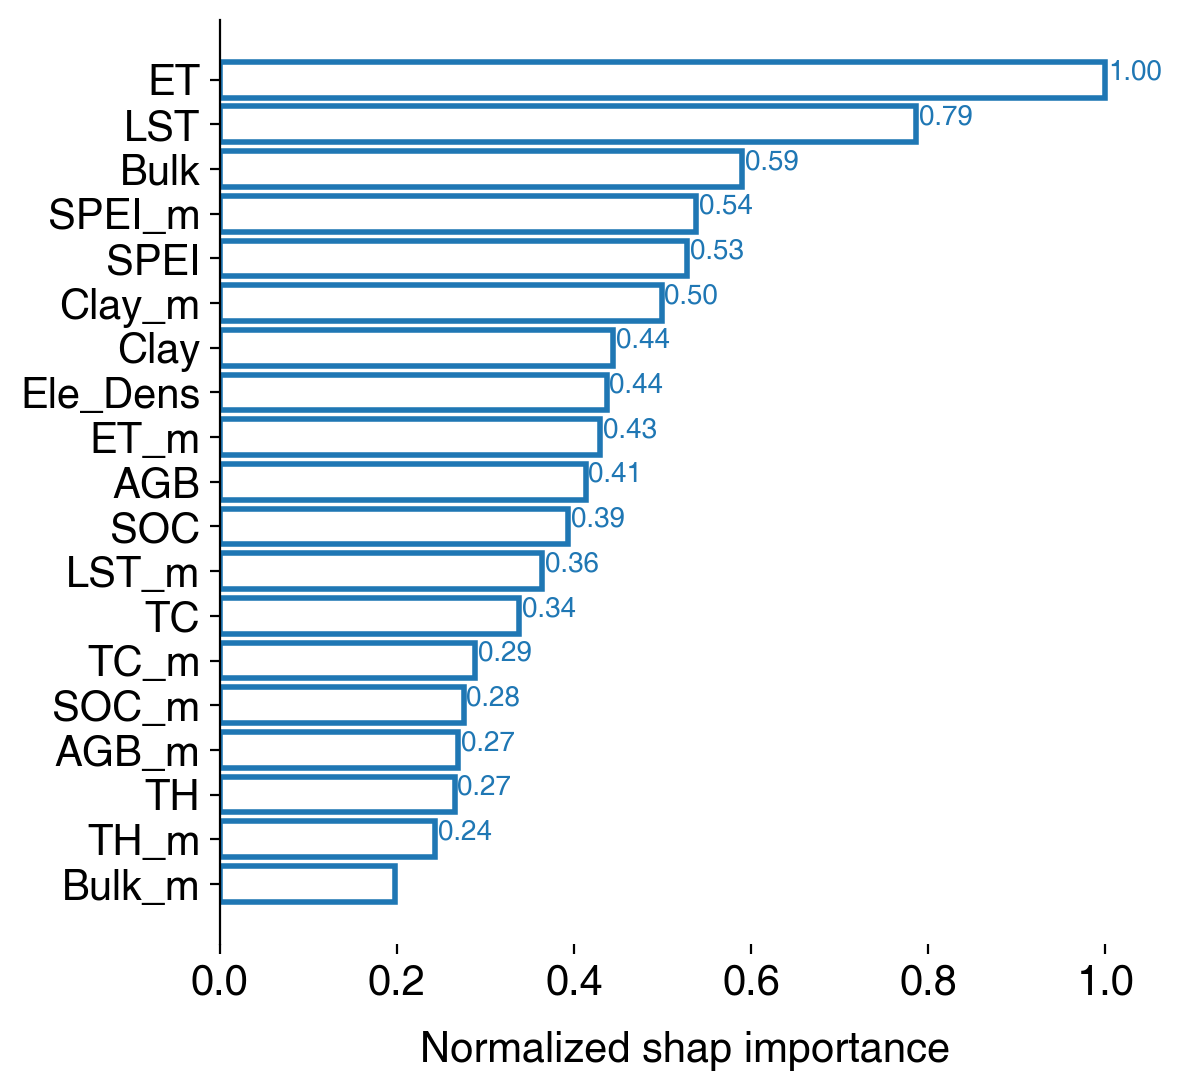

In [30]:
import shap
from sklearn.inspection import permutation_importance
explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
# SHAP value
shap_values = explainer.shap_values(X_test)
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=0)
# normalized
normalized_shap_importance = np.abs(shap_values).mean(axis=0) / np.max(np.abs(shap_values).mean(axis=0))
normalized_perm_importance = perm_importance.importances_mean / np.max(perm_importance.importances_mean)
# ascending
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'SHAP Importance': normalized_shap_importance, 'Perm Importance': normalized_perm_importance})
feature_importance_df = feature_importance_df.sort_values(by='SHAP Importance', ascending=False)
labels=list(reversed([i for i in feature_importance_df['Feature']]))
value=list(reversed([i for i in feature_importance_df['SHAP Importance']]))
#Fig
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#fig.subplots_adjust(wspace=0.2,hspace=0.4, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 16}
plt.rc('font', **font)  # pass in the font dict as kwargs
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6), sharex=False,sharey=False)
for i in range(len(value)):
    if value[i]>=0.2:
        ax.barh(labels[i], value[i], color='none',edgecolor='C0', linewidth=2,label='Shapley value')
    else:
        ax.barh(labels[i], value[i], color='none',edgecolor='C0', linewidth=2,label='Shapley value')
for a,b in zip(value,labels): # 添加数字标签
    print(a,b)
    if a>=0.2:
        ax.text(a+0.003, b,'%.2f'%float(a), color='C0',fontsize =10) # a+0.001代表标签位置在柱形图上方0.001处
ax.tick_params(labelsize=15)
#ax.set_xlim(0, 0.18)
#ax.set_xticks(np.arange(0, 0.18,0.05))
ax.set_xlabel('Normalized shap importance',fontsize =15,labelpad=10) # x 轴
#ax3.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)